<a href="https://colab.research.google.com/github/patel-zeel/Nonstat-exps/blob/main/GP_Extra_whitekernel_added_RBF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!git clone https://github.com/jmetzen/gp_extras.git
!cd gp_extras;python setup.py install;
!pip -qq install pods
clear_output()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RBF, WhiteKernel
from gp_extras.kernels import ManifoldKernel, LocalLengthScalesKernel, HeteroscedasticKernel
from sklearn.preprocessing import StandardScaler

# Local lengthscale kernel

Tries to learn 2 level GP by learning lengthscale locally for few points without affecting overall fit.

## Step function

shape of train_X= (20, 1) shape of train_y= (20, 1)


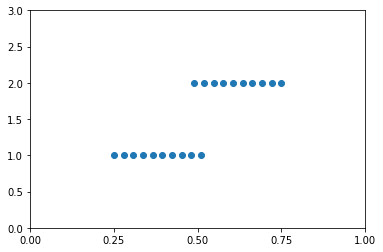

In [3]:
train_X = np.concatenate([np.linspace(0.25,0.51,10), np.linspace(0.49,0.75,10)]).reshape(-1,1)
train_y = np.concatenate([np.ones((10, 1)), np.ones((10, 1))*2])
test_X = np.linspace(0,1,120).reshape(-1,1)
print("shape of train_X=",train_X.shape, "shape of train_y=",train_y.shape)
plt.scatter(train_X, train_y)
plt.ylim(0,3);plt.xticks([0,0.25,0.5,0.75,1]);

## Defining stationary and non-stationary GPs (gp and nonstat_gp)

In [4]:
# Stationary kernel
def sklearn_gp(K):
  kernel = C() * K + WhiteKernel()
  return GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)

# Non stationary kernel
from scipy.optimize import differential_evolution
def LLS_gp(n_samples):
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  def de_optimizer(obj_func, initial_theta, bounds):
      res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                  bounds, maxiter=20, disp=False, polish=False)
      return res.x, obj_func(res.x, eval_gradient=False)
  nonstat_kernel = (C() * LocalLengthScalesKernel.construct(train_XX, l_samples=n_samples)) + WhiteKernel()
  return GaussianProcessRegressor(kernel=nonstat_kernel, alpha=1e-5,
                                n_restarts_optimizer=10, random_state=0, optimizer=de_optimizer)

In [5]:
gp = sklearn_gp(RBF())
nonstat_gp = lambda n: LLS_gp(n)
print("Stationary kernel=\n", gp.kernel,sep='',end='\n\n')
print("LLS kernel=\n", nonstat_gp(1).kernel,sep='')

Stationary kernel=
1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)

LLS kernel=
1**2 * LocalLengthScalesKernel(theta_gp=[0.1], theta_l=[0.1], length_scales=[1.]) + WhiteKernel(noise_level=1)


## Testing on step function

Stationary RBF 1.32**2 * RBF(length_scale=1.74) + WhiteKernel(noise_level=0.0711)
Stationary time 0.34242868423461914
LLS RBF, n_samples= 1 2.55**2 * LocalLengthScalesKernel(theta_gp=[0.01426126], theta_l=[0.12924827], length_scales=[0.10237215]) + WhiteKernel(noise_level=3.59e-05)
NS time, samples 1 31.81240963935852
LLS RBF, n_samples= 2 1.42**2 * LocalLengthScalesKernel(theta_gp=[0.00106018], theta_l=[0.8335451], length_scales=[0.72731613 2.08955989]) + WhiteKernel(noise_level=0.062)
NS time, samples 2 39.55441474914551
LLS RBF, n_samples= 3 3.19**2 * LocalLengthScalesKernel(theta_gp=[0.01769564], theta_l=[0.14537406], length_scales=[0.15209615 1.1604356  0.87232162]) + WhiteKernel(noise_level=6.91e-05)
NS time, samples 3 44.990835189819336
LLS RBF, n_samples= 4 2.03**2 * LocalLengthScalesKernel(theta_gp=[0.00173291], theta_l=[0.46433807], length_scales=[1.71487299 0.98672543 1.71232047 0.96341798]) + WhiteKernel(noise_level=0.0573)
NS time, samples 4 52.95498991012573
LLS RBF, n_sa

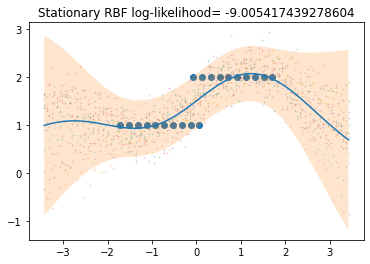

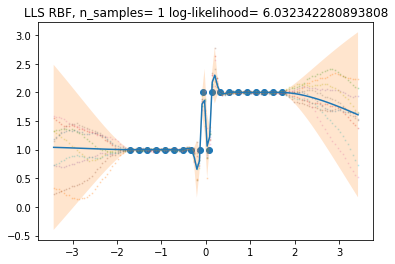

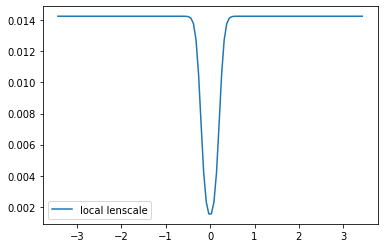

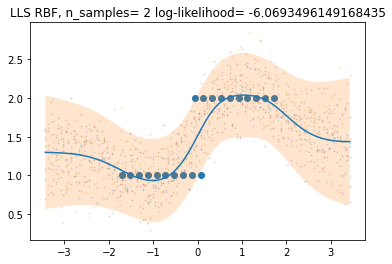

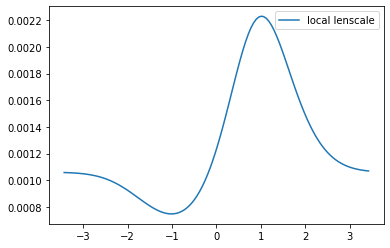

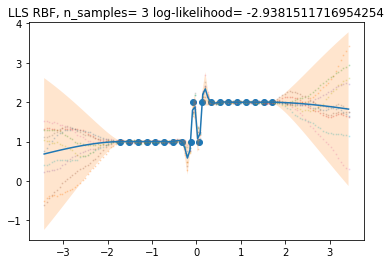

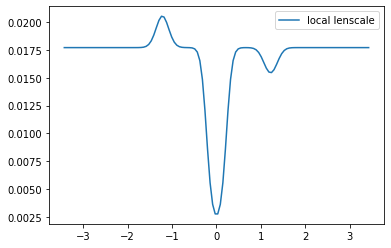

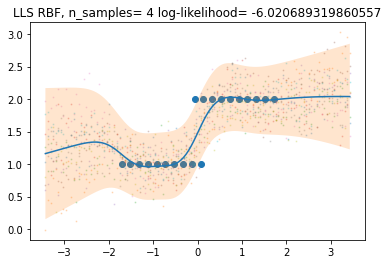

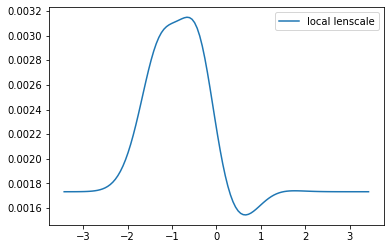

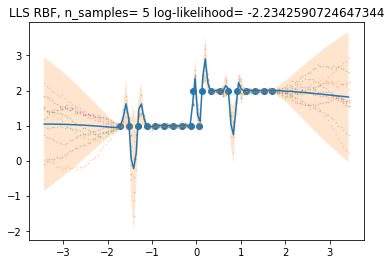

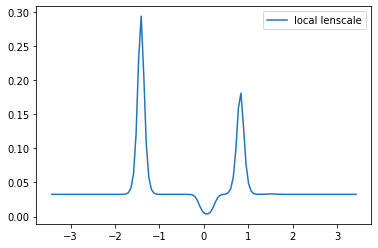

In [6]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = reg.sample_y(test_XX, n_samples=10).squeeze().T
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.title(name+' log-likelihood= '+str(reg.log_marginal_likelihood_value_))
  if name.startswith("LLS"):
    plt.figure()
    plt.plot(test_XX.reshape(-1), reg.kernel_.k1.k2.theta_gp
             * 10**reg.kernel_.k1.k2.gp_l.predict(test_XX.reshape(-1)[:, np.newaxis]), label='local lenscale')
    plt.legend()
  print(name, reg.kernel_)
  return reg

# Stationary
init = time()
_ = fit_predict_plot(gp, 'Stationary RBF')
print("Stationary time", time()-init)

# Non-Stationary n_samples
for n_samples in range(1,6):
  init=time()
  fit_predict_plot(nonstat_gp(n_samples), 'LLS RBF, n_samples= '+str(n_samples))
  print("NS time, samples", n_samples, time()-init)

## Olympic marathon data

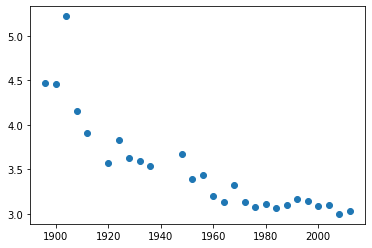

In [7]:
import pods
data = pods.datasets.olympic_marathon_men()
clear_output()
train_X = data['X']
test_X = np.linspace(data['X'].min()-10, data['X'].max()+10, 120).reshape(-1,1)
train_y = data['Y']
plt.scatter(train_X, train_y);

scaler = StandardScaler()
train_XX = scaler.fit_transform(train_X)
nonstat_kernel = lambda n: (C()*LocalLengthScalesKernel.construct(train_XX, l_samples=n)) + WhiteKernel()
def de_optimizer(obj_func, initial_theta, bounds):
      res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                  bounds, maxiter=20, disp=False, polish=False)
      return res.x, obj_func(res.x, eval_gradient=False)
nonstat_gp = lambda n: GaussianProcessRegressor(kernel=nonstat_kernel(n), alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0, optimizer=de_optimizer)

## Testing

Stationary RBF 5.04**2 * RBF(length_scale=4.28) + WhiteKernel(noise_level=0.0485)
Stationary time 0.3699667453765869
LLS RBF, n_samples= 1 3.62**2 * LocalLengthScalesKernel(theta_gp=[0.07002161], theta_l=[3.12875214], length_scales=[7.54419313]) + WhiteKernel(noise_level=0.0475)
NS time, samples 1 35.718994140625
LLS RBF, n_samples= 2 1.76**2 * LocalLengthScalesKernel(theta_gp=[0.49605319], theta_l=[2.12320131], length_scales=[6.78242607 0.70298003]) + WhiteKernel(noise_level=0.00847)
NS time, samples 2 43.54271078109741
LLS RBF, n_samples= 3 2.45**2 * LocalLengthScalesKernel(theta_gp=[0.01300604], theta_l=[9.33529592], length_scales=[1.24880285 0.16989423 2.06319692]) + WhiteKernel(noise_level=0.0067)
NS time, samples 3 50.63412547111511
LLS RBF, n_samples= 4 4.24**2 * LocalLengthScalesKernel(theta_gp=[0.0054117], theta_l=[0.00123314], length_scales=[0.96609523 1.01145101 0.11509039 1.3871991 ]) + WhiteKernel(noise_level=0.00726)
NS time, samples 4 57.96753787994385
LLS RBF, n_samples

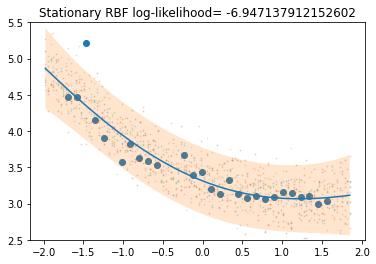

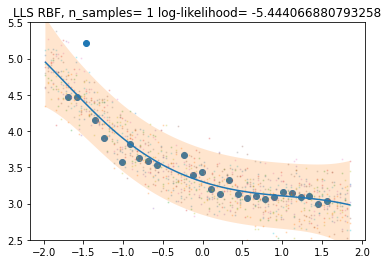

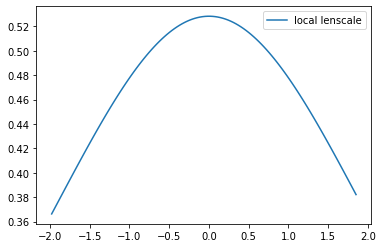

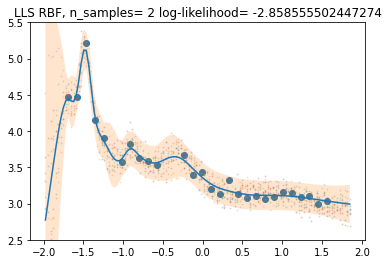

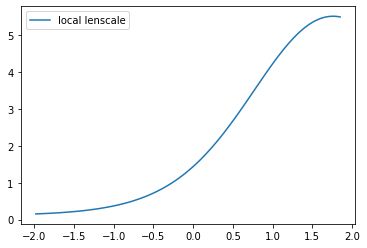

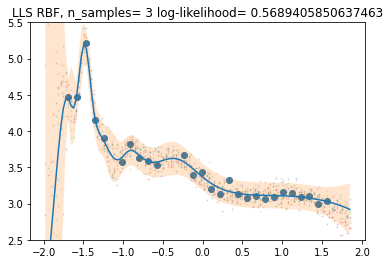

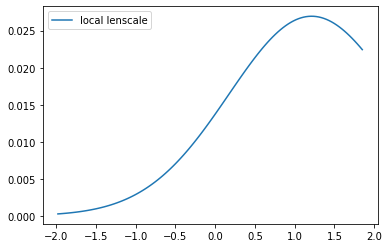

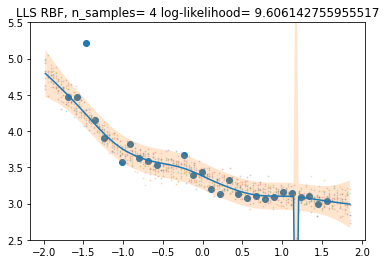

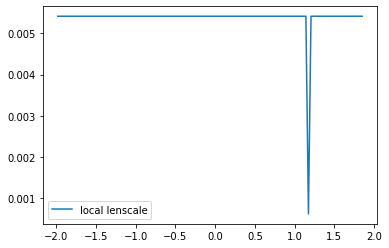

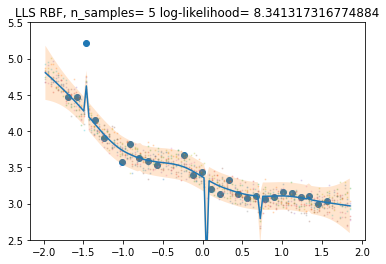

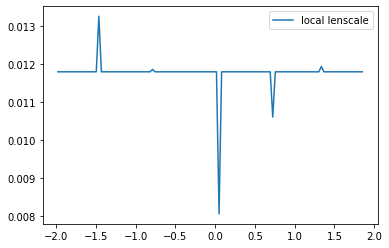

In [8]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = reg.sample_y(test_XX, n_samples=10).squeeze().T
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.ylim(2.5,5.5)
  plt.title(name+' log-likelihood= '+str(reg.log_marginal_likelihood_value_))
  if name.startswith("LLS"):
    plt.figure()
    plt.plot(test_XX.reshape(-1), reg.kernel_.k1.k2.theta_gp
             * 10**reg.kernel_.k1.k2.gp_l.predict(test_XX.reshape(-1)[:, np.newaxis]), label='local lenscale')
    plt.legend()
  print(name, reg.kernel_)
  return reg

# Stationary
init = time()
fit_predict_plot(gp, 'Stationary RBF')
print("Stationary time", time()-init)

# Non-Stationary n_samples
for n_samples in range(1,6):
  init=time()
  fit_predict_plot(nonstat_gp(n_samples), 'LLS RBF, n_samples= '+str(n_samples))
  print("NS time, samples", n_samples, time()-init)

## 4 functions joint

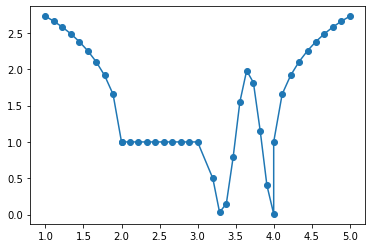

In [9]:
train_X1 = np.linspace(1,2,10);train_X2 = np.linspace(2,3,10);train_X3 = np.linspace(3.2,4,10);train_X4 = np.linspace(4,5,10);
train_y1 = np.sqrt(4-train_X1**2)+1;train_y2 = np.ones(10);train_y3 = np.sin(train_X3*9)+1;train_y4 = np.sqrt(((2)**2)-(train_X1-3)**2)+1;
train_X = np.concatenate([train_X1, train_X2, train_X3, train_X4]).reshape(-1,1)
test_X = np.linspace(0,6,60).reshape(-1,1)
train_y = np.concatenate([train_y1, train_y2, train_y3, train_y4]).reshape(-1,1)
plt.plot(train_X, train_y,'o-');

scaler = StandardScaler()
train_XX = scaler.fit_transform(train_X)
nonstat_kernel = lambda n: (C()*LocalLengthScalesKernel.construct(train_XX, l_samples=n)) + WhiteKernel()
def de_optimizer(obj_func, initial_theta, bounds):
      res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                  bounds, maxiter=20, disp=False, polish=False)
      return res.x, obj_func(res.x, eval_gradient=False)
nonstat_gp = lambda n: GaussianProcessRegressor(kernel=nonstat_kernel(n), alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0, optimizer=de_optimizer)

Stationary RBF 1.56**2 * RBF(length_scale=0.219) + WhiteKernel(noise_level=0.0374)
Stationary time 0.5068509578704834
LLS RBF, n_samples= 1 1.6**2 * LocalLengthScalesKernel(theta_gp=[0.06528252], theta_l=[0.81736255], length_scales=[0.10211303]) + WhiteKernel(noise_level=0.0335)
NS time, samples 1 61.62578630447388
LLS RBF, n_samples= 2 2.2**2 * LocalLengthScalesKernel(theta_gp=[0.0481918], theta_l=[0.38188828], length_scales=[0.66738941 0.12440194]) + WhiteKernel(noise_level=0.0315)
NS time, samples 2 73.6575117111206
LLS RBF, n_samples= 3 1.84**2 * LocalLengthScalesKernel(theta_gp=[0.01066116], theta_l=[0.99302706], length_scales=[6.6543623  8.71386472 0.12663199]) + WhiteKernel(noise_level=0.0332)
NS time, samples 3 86.15960574150085
LLS RBF, n_samples= 4 2.8**2 * LocalLengthScalesKernel(theta_gp=[0.05012952], theta_l=[0.18920419], length_scales=[1.08961418 1.12666636 0.1177022  1.23493698]) + WhiteKernel(noise_level=0.0236)
NS time, samples 4 98.4669258594513
LLS RBF, n_samples= 5 

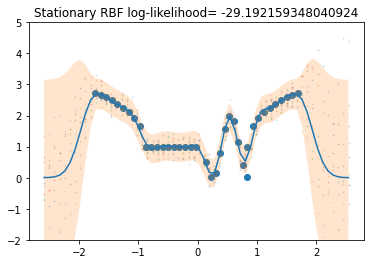

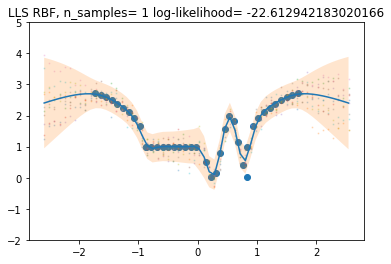

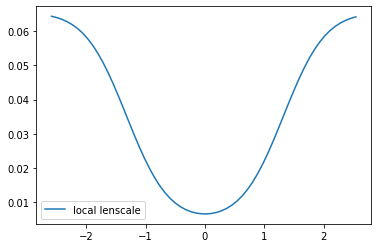

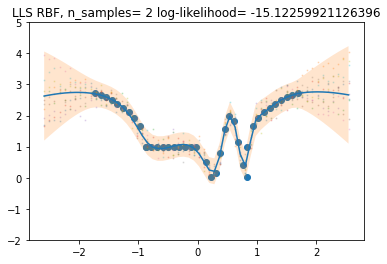

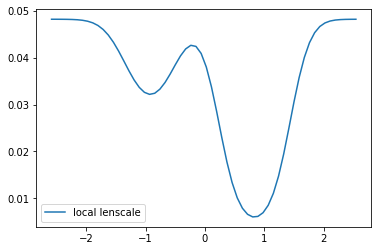

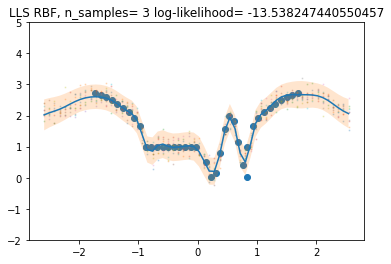

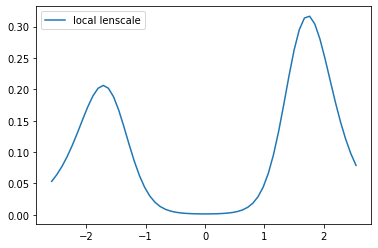

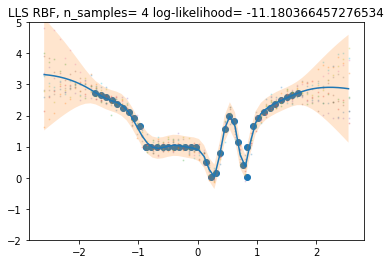

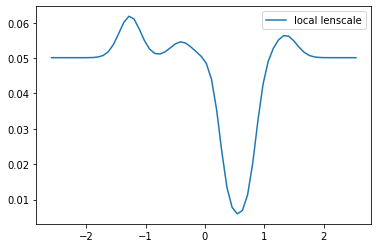

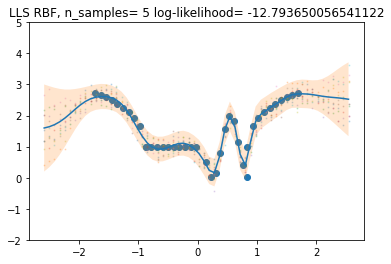

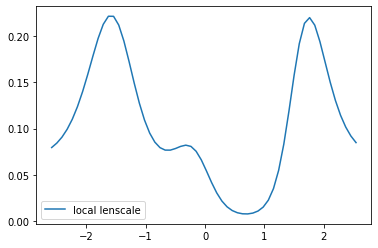

In [10]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = reg.sample_y(test_XX, n_samples=10).squeeze().T
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.ylim(-2, 5)
  plt.title(name+' log-likelihood= '+str(reg.log_marginal_likelihood_value_))
  if name.startswith("LLS"):
    plt.figure()
    plt.plot(test_XX.reshape(-1), reg.kernel_.k1.k2.theta_gp
             * 10**reg.kernel_.k1.k2.gp_l.predict(test_XX.reshape(-1)[:, np.newaxis]), label='local lenscale')
    plt.legend()
  print(name, reg.kernel_)
  return reg

# Stationary
init = time()
fit_predict_plot(gp, 'Stationary RBF')
print("Stationary time", time()-init)

# Non-Stationary n_samples
for n_samples in range(1,6):
  init=time()
  fit_predict_plot(nonstat_gp(n_samples), 'LLS RBF, n_samples= '+str(n_samples))
  print("NS time, samples", n_samples, time()-init)

# Manifold kernel (work under progress)

Works similar to the neural network kernel. We can map individual features to multiple dimentions via seperate neural net architectures.

## Defining Stationary and Non-stationary GP (gp and nonstat_gp)

In [11]:
# sklearn
kernel = C() * RBF()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)

# Non stationary kernel
nonstat_kernel = C()\
                *ManifoldKernel.construct(base_kernel=RBF(), architecture=((1, 2),),
                               transfer_fct="relu", max_nn_weight=1)
# architecture is neural net architecture (input_dim, hidden1_dim, hidden2_dim, ..., output_dim)
nonstat_gp = GaussianProcessRegressor(kernel=nonstat_kernel, alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0)

print("sklearn kernel=\n", kernel,sep='',end='\n\n')
print("Manifold kernel=\n", nonstat_kernel,sep='')

sklearn kernel=
1**2 * RBF(length_scale=1)

Manifold kernel=
1**2 * ManifoldKernel(0.358, -0.27, -0.271, 0.401, 0)


## Testing on step function

RBF 208**2 * RBF(length_scale=0.0683)


/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Manifold RBF 1.35**2 * ManifoldKernel(-0.00612, 0.445, 0.214, -1, -7.12)


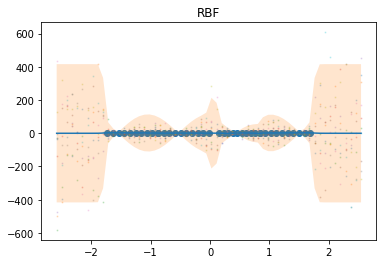

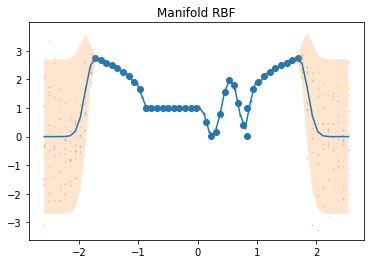

In [12]:
def fit_predict_plot(reg, name): # _XX refers to scaled variable
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  reg.fit(train_XX, train_y)
  pred_y, cov_y = reg.predict(test_XX, return_cov=True)
  std_y = cov_y.diagonal()**0.5
  plt.scatter(train_XX, train_y)
  post_samples = np.random.multivariate_normal(pred_y.reshape(-1), cov_y, 10)
  for i in range(10):
    plt.scatter(test_XX.reshape(-1), post_samples[i], s=1, alpha=0.2)
  plt.plot(test_XX, pred_y)
  plt.fill_between(test_XX.reshape(-1), pred_y.reshape(-1)-2*std_y, pred_y.reshape(-1)+2*std_y, alpha=0.2)
  plt.title(name)
  print(name, reg.kernel_)

# Stationary
fit_predict_plot(gp, 'RBF')
# Non-Stationary
fit_predict_plot(nonstat_gp, 'Manifold RBF')

# Appendix

In [13]:
#!pip -qq install pods
#!pip -qq install GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
import pods
data = pods.datasets.olympic_marathon_men()
X = data['X']
y = data['Y']
# scikit-learn
model = GaussianProcessRegressor(C()*RBF(), n_restarts_optimizer=20, random_state=0)
model.fit(X, y)
print(model.kernel_)
model.sample_y(X, n_samples=10, random_state=0).shape

# GPy
from GPy.models import GPRegression
from GPy.kern import RBF as GPyRBF
model = GPRegression(X, y, GPyRBF(1))
model.optimize_restarts(20, verbose=0)
print(model.kern)

2.89**2 * RBF(length_scale=6.15)


ModuleNotFoundError: ignored